In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 3
s1 = 0.02
m1 = 0.
dim = [3,4]

params = []
params.append(np.random.normal(size=dim))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1)

In [3]:
params.shape

(3, 3, 4)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=0.2)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X) + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype('float32')

In [6]:
xs

array([[[ 0.12471295, -0.3227948 ,  0.8416747 ],
        [ 1.8146483 , -0.2740281 ,  2.5724974 ],
        [ 4.590592  , -0.34078658,  4.660271  ]]], dtype=float32)

In [7]:
def create_step_flow(name=None, prev_flow_output=None):
    with tf.variable_scope(name, reuse=None):
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(8)])
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0')]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1])
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 3, 12) dtype=float32>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_2:0' shape=() dtype=float32>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.2, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 3, 3)

In [17]:
logl

<tf.Tensor 'add_6:0' shape=() dtype=float32>

In [18]:
ent = sum([flow.logdens for flow in flows])

In [19]:
ent

<tf.Tensor 'add_9:0' shape=(1,) dtype=float32>

In [20]:
loss = -logl - prior + ent
loss /= 20*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [33]:
for _ in range(100):
    for _ in range(1000):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)

[0.95094466]
[0.9792895]
[0.8157001]
[0.901979]
[0.7723801]
[0.7926884]
[0.93762285]
[0.8795294]
[0.85128635]
[0.9339587]
[0.9202455]


KeyboardInterrupt: 

In [25]:
out = tf.reshape(outputs, [n, 3, 4])

In [34]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append([s[0,0,0], s[1,0,0]])
samples = np.array(samples)

In [35]:
samples

array([[ 0.27442366,  0.22010733],
       [-0.23111993, -0.21187286],
       [ 0.3771994 ,  0.3602257 ],
       ...,
       [ 0.74887466,  0.7610903 ],
       [ 0.69985306,  0.7863555 ],
       [ 0.04342179,  0.03201954]], dtype=float32)

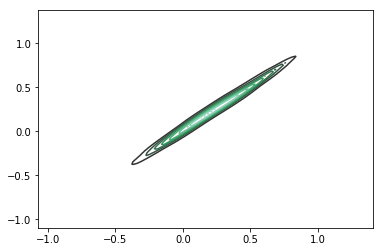

In [36]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()